# Problem set 2 (35 + 55 + 15 + 28 = 133 pts)

## Problem 1 (LU decomposition) 35 pts


### 1. LU for band matrices (7 pts)

The complexity to find an LU decomposition of a dense $n\times n$ matrix is $\mathcal{O}(n^3)$.
Significant reduction in complexity can be achieved if the matrix has a certain structure, e.g. it is sparse. 
In the following task we consider an important example of $LU$ for a special type of sparse matrices –– band matrices with the bandwidth $m$ equal to 3 or 5 which called tridiagonal and pentadiagonal respectively.

- (5 pts) Write a function ```band_lu(diag_broadcast, n)``` which computes LU decomposition for tridiagonal or pentadiagonal matrix with given diagonal values. 
For example, input parametres ```(diag_broadcast = [4,-2,1], n = 4)``` mean that we need to find LU decomposition for the triangular matrix of the form:

$$A = \begin{pmatrix}
-2 & 1 & 0 & 0\\
4 & -2 & 1 & 0 \\
0 & 4 & -2 & 1 \\
0 & 0 & 4 & -2 \\
\end{pmatrix}.$$

As an output it is considered to make ```L``` and ```U``` - 2D arrays representing diagonals in factors $L$ (```L[0]``` keeps first lower diagonal, ```L[1]``` keeps second lower, ...), and $U$ (```U[:,0]``` keeps main diagonal, ```U[:,1]``` keeps first upper, ...).
- (2 pts) Compare execution time of the band LU decomposition using standard function from ```scipy```, i.e. which takes the whole matrix and does not know about its special structure, and band decomposition of yours implementation. Comment on the results.

#### Q 1.1

In [1]:
from scipy.sparse import diags # can be used with broadcasting of scalars if desired dimensions are large
import numpy as np
import scipy 

# INPUT : diag_broadcast - list of diagonals value to broadcast,length equal to 3 or 5; n - integer, band matrix shape.
# OUTPUT : L - 2D np.ndarray, L.shape[0] depends on bandwidth, L.shape[1] = n-1, do not store main diagonal, where all ones;                  add zeros to the right side of rows to handle with changing length of diagonals.
#          U - 2D np.ndarray, U.shape[0] = n, U.shape[1] depends on bandwidth;
#              add zeros to the bottom of columns to handle with changing length of diagonals.

def band_lu(diag_broadcast, n):
    if len(diag_broadcast) == 3:
        U = np.zeros((2, n))
        U[0][0] = diag_broadcast[1]
        U_1 = diags([diag_broadcast[2]], 2, shape = U.shape).toarray()
        U += U_1

        L = np.zeros((1, n))
        for i in range(1, n):
            L[0][i] = diag_broadcast[0] / U[0][i-1]
            U[0][i] = diag_broadcast[1] - L[0][i] * diag_broadcast[2]
   
    if len(diag_broadcast) == 5:
        U = np.zeros((3, n))
        U[0][0] = diag_broadcast[2]
        U[1][0] = diag_broadcast[3]
        U_2 = diags([diag_broadcast[4]], 3, shape = U.shape).toarray()
        U += U_2

        L = np.zeros((2, n))
        for i in range(1, n):
            L[0][i] = (diag_broadcast[1] - L[1][i-1] * U[1][i-2]) / U[0][i-1]
            U[0][i] = diag_broadcast[2] - L[0][i] * U[1][i-1] - L[1][i-1] * U[2][i-2]
            L[1][i] = diag_broadcast[0] / U[0][i-1]
            U[1][i] = diag_broadcast[3] - L[0][i-1] * U[2][i-1]
        U[1][n-1] = 0
        L[1][n-1] = 0

    U = U.T
    return L[:, 1:], U

#### Q 1.2

In [2]:
from scipy.linalg import lu

n=5
diag_broadcast = [15, 48, -1]
A = diags(diag_broadcast, [-1, 0, 1], shape = (n, n)).toarray()

t1 = []
t2 = []
sizes = np.arange(5, 1000, 100)
for n  in sizes:
    A = diags(diag_broadcast, [-1, 0, 1], shape = (n, n)).toarray()
    t = %timeit -o -q band_lu(diag_broadcast, n)
    t1.append(t.average)
    t = %timeit -o -q lu(A)
    t2.append(t.average)

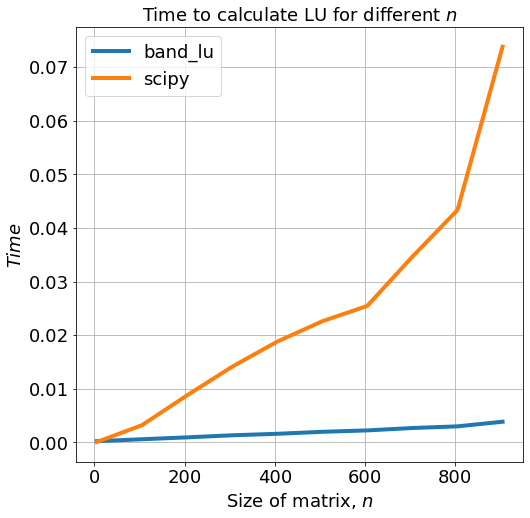

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot(sizes, t1, label="band_lu", linewidth=4)
plt.plot(sizes, t2, label="scipy", linewidth=4)
plt.legend(fontsize=18)
plt.ylabel(r"$Time$", fontsize=18)
plt.xlabel(r"Size of matrix, $n$", fontsize=18)
plt.grid(True)
plt.title(r"Time to calculate LU for different $n$", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);

From the figure above, we can see that our function is faster with factorization than the built-in function since it uses additional information about the matrix structure. The complexity of this algorithm is O(n), and the dependence on the matrix size is linear.

### 2. Stability of LU (8 pts)

Let
$A = \begin{pmatrix}
\varepsilon & 1 & 0\\
1 & 1 & 1 \\
0 & 1 & 1
\end{pmatrix}.$ 
* (5 pts) Find analytically LU decomposition with and without pivoting for the matrix $A$.
* (3 pts) Explain, why can the LU decomposition fail to approximate factors $L$ and $U$ for $|\varepsilon|\ll 1$ in computer arithmetic?

#### Q 2.1

Without pivoting:
$A = \begin{pmatrix}\varepsilon & 1 & 0\\1 & 1 & 1\\0 & 1 & 1\end{pmatrix}=LU=$
$\begin{pmatrix} 1 & 0 & 0\\L_{21} & 1 & 0\\L_{31} & L_{32} & 1\end{pmatrix}$
$\begin{pmatrix} U_{11} & U_{12} & U_{13}\\0 & U_{22} & U_{23}\\0 & 0 & U_{33}\end{pmatrix}=$
$=\begin{pmatrix} U_{11} & U_{12} & U_{13}\\L_{21} U_{11} & L_{21}U_{12}+U_{22} & L_{21}U_{13}+U_{23}\\L_{31} U_{11} & L_{31}U_{12}+L_{32}U_{22} & L_{31}U_{13}+L_{32}U_{23}+U_{33}\end{pmatrix}$  

$U_{11}=\varepsilon$; $U_{12}=1$; $ U_{13}=0$  
$L_{21}=\frac1{\varepsilon}$; $U_{22}=1-\frac1{\varepsilon}$; $ U_{23}=1$  
$L_{31}=0$; $L_{32}=\frac1{1-\frac1{\varepsilon}}$; $U_{33}=1-\frac1{1-\frac1{\varepsilon}}$

$\begin{pmatrix}\varepsilon & 1 & 0\\1 & 1 & 1\\0 & 1 & 1\end{pmatrix}=$
$\begin{pmatrix}1 & 0 & 0\\ \frac1{\varepsilon} & 1 & 0\\0 & \frac1{1-\frac1{\varepsilon}} & 1\end{pmatrix}$
$\begin{pmatrix}\varepsilon & 1 & 0\\0 & 1-\frac1{\varepsilon} & 1\\0 & 0 & 1-\frac1{1-\frac1{\varepsilon}}\end{pmatrix}$

With pivoting:
$\quad R_1<=>R_2: P = \begin{pmatrix}0 & 1 & 0\\1 & 0 & 0\\0 & 0 & 1\end{pmatrix}, \quad A=\begin{pmatrix}1 & 1 & 1\\ \varepsilon & 1 & 0\\0 & 1 & 1\end{pmatrix}. Assume \ 0<\varepsilon<1:$

$R_2-\varepsilon R_1 \rightarrow R_1: \quad \begin{pmatrix}1 & 1 & 1\\ 0 (\pmb{\varepsilon}) & 1-\varepsilon & -\varepsilon\\0 & 1 & 1\end{pmatrix}$

$R_3-0R_1 \rightarrow R_1: \quad \begin{pmatrix}1 & 1 & 1\\ 0 (\pmb{\varepsilon}) & 1-\varepsilon & -\varepsilon\\ 0 (\pmb{0}) & 1 & 1\end{pmatrix}$

$\quad R_2<=>R_3: P=\begin{pmatrix}0 & 1 & 0\\0 & 0 & 1\\0 & 0 & 1\end{pmatrix},  \quad \begin{pmatrix}1 & 1 & 1\\ 0 (\pmb{0}) & 1 & 1\\ 0 (\pmb{\varepsilon}) & 0 (\pmb{1-\varepsilon}) & -\varepsilon\end{pmatrix}$

$R_3-(1-\varepsilon)R_3 \rightarrow R_3: \quad \begin{pmatrix}1 & 1 & 1\\ 0(\pmb{0}) & 1 & 1\\ 0 (\pmb{\varepsilon}) & 0 (\pmb{1-\varepsilon}) & -\varepsilon^2\end{pmatrix}$

$LU=\begin{pmatrix}1 & 0 & 0\\ 0 & 1 & 0\\\varepsilon & 1-\varepsilon & 1\end{pmatrix} \quad \begin{pmatrix}1 & 1 & 1\\ 0 & 1 & 1\\ 0 & 0 & -\varepsilon^2\end{pmatrix}$

#### Q 2.2

Instability issue: will have too large element in the matrix L. Norms of L and U will be both large while A will have small norm - ill-conditioned representation symptom.

### 3. Block LU (10 pts)

Let $A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}$ be a block matrix. The goal is to solve the linear system

$$
     \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} f_1 \\ f_2 \end{bmatrix}.
$$

* (2 pts) Using block elimination find matrix $S$ and right-hand side $\hat{f_2}$ so that $u_2$ can be found from $S u_2 = \hat{f_2}$. Note that the matrix $S$ is called <font color='red'> Schur complement </font> of the block $A_{11}$.
* (4 pts) Using Schur complement properties prove that 

$$\det(X+AB) = \det(X)\det(I+BX^{-1}A), $$


where $X$ - nonsingular square matrix.
* (4 pts) Let matrix $F \in \mathbb{R}^{m \times n}$ and $G \in \mathbb{R}^{n \times m}$. Prove that 

$$\det(I_m - FG) = \det(I_n - GF).$$

#### Q 3.1

$\begin{bmatrix} A_{11} & A_{12}\\ A_{21} & A_{22}\end{bmatrix}\begin{bmatrix}u_{1}\\ u_{2} \end{bmatrix}=\begin{bmatrix}f_{1}\\ f_{2} \end{bmatrix}$

Eliminate $u_1$:  
$u_1=A_{11}^{-1}(f_1-A_{12}u_2)$  
$(A_{22}-A_{21}A_{11}^{-1}A_{12})u_2=f_2-A_{21}A_{11}^{-1}f_1$ or  
$Su_2=\hat{f_{2}}$, where $S=A_{22}-A_{21}A_{11}^{-1}A_{12}$ and $\hat{f_2}=f_2-A_{21}A_{11}^{-1}f_1.$

#### Q 3.2

$X$ is nonsingular square matrix => $X$ is invertible. 
For the case $X=I$:  
${\begin{pmatrix}I & 0 \\ B & 1\end{pmatrix}}{\begin{pmatrix}I+AB & A \\ 0 & 1\end{pmatrix}}{\begin{pmatrix}I & 0 \\ -B & 1\end{pmatrix}}= {\begin{pmatrix}I & A \\ 0 & 1+BA\end{pmatrix}}$  
=> $\det(I+AB)=(1+BA).$  

The general case: $\det(X+AB)=\det(X)\det(I+(X^{-1}A)B) = \det(A)\det(1+BX^{-1}A)$ for $X$ that is invertible.

#### Q 3.3

Let the matrix containing 4 blocks $I_m,G,F,I_n$ be in $M$:  
$M=\begin{pmatrix}I_m & F \\ G & I_n\end{pmatrix}$  
$\det{\begin{pmatrix}I_m & F \\ G & I_n\end{pmatrix}}=\det(I_m)\det(I_n-GI_m^1F) = \det(I_n-GF)$ as $I_m$ is invertible,
$\det{\begin{pmatrix}I_m & F \\ G & I_n\end{pmatrix}}=\det(I_n)\det(I_m-FI_n^1G) = \det(I_m-FG)$ as $I_n$ is invertible,  
=> $\det(I_m-FG)=\det(I_n-GF).$

### 4. Efficient implementation of LU decomposition (10 pts)

In the lecture we provide naive implementation of LU factorization with loops and elementwise update of factors. In this subproblem we ask you to provide more efficient implementation of LU factorization and explain how you derive this implementation (main ideas and how you use them in this particular case). 
- (1 pts) Main idea for speed up computation of LU factorization (without using built-in function!) 
- (4 pts) Implement the presented approach to speed up LU 
- (1 pts) Illustrate numerically that your implementation is correct
- (2 pts) Provide the comparison of running time of naive implementation from the lecture, your implementation and NumPy built-in function for range of matrix dimensions. We expect you plot the running time vs matrix dimension for these implementations. So you should get the plot with three lines.
- (2 pts) Discuss the obtained results and explain what other tricks are possible to accelerate computing the LU factorization. 

NumPy or JAX are both ok in this subproblem, but please use the single library for all implementations. 

In the problem 1.2.1 LU was computed by so called "Doolittle" algorithm. It allows us to compute LU without going through the hassle of Gaussian Elimination:
"We assume that an LU decomposition exists, and write the form of L and U explicitly. We then systematically solve for the entries in L and U from the equations that result from the multiplications necessary for A=LU".

In [4]:
MAX = 100
def lu_decomposition(A, n):
    lower = [[0 for x in range(n)]
             for y in range(n)]
    upper = [[0 for x in range(n)]
             for y in range(n)]
    for i in range(n):
        for k in range(i, n):
            sum = 0
            for j in range(i):
                sum += (lower[i][j] * upper[j][k])
            upper[i][k] = A[i][k] - sum
        for k in range(i, n):
            if (i == k):
                lower[i][i] = 1
            else:
                sum = 0
                for j in range(i):
                    sum += (lower[k][j] * upper[j][i])
                lower[k][i] = int((A[k][i] - sum) /
                                  upper[i][i])
    print("  L\t\t                 U")
    for i in range(n):
        for j in range(n):
            print(lower[i][j], end="\t")
        print("", end="\t")
        for j in range(n):
            print(upper[i][j], end="\t")
        print("")
        
import time
start = time.time()
A = ([[1., 2., 3.],
       [4., 5., 6.],
       [6., 2., 3.]])
lu_decomposition(A, 3)
end = time.time()
t1 = end - start
t1

  L		                 U
1	0	0		1.0	2.0	3.0	
4	1	0		0	-3.0	-6.0	
6	3	1		0	0	3.0	


0.0

In [5]:
start = time.time()
n = 4
diag_broadcast = [1,2,3]
A = diags(np.vstack(diag_broadcast), [-1, 0, 1], shape=(n, n), format='csr')
from scipy.sparse.linalg import splu
T = splu(A.tocsc(), permc_spec="NATURAL")
L = T.L.toarray()
U = T.U.toarray()
end = time.time()
t2 = end - start
t2

0.09059882164001465

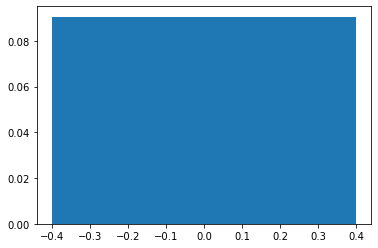

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(t1, t2);

The time for the Doolittle algorithm was less than for LU computation with splu. However, there are, in my view, two the main drawbacks of the proposed algorithm: 1) It begins with the assumption that LU factorization exists without actually checking it. 2) It can be applied only for square matrices. Other possible ways of LU decomposition: Recursive algorithm for LUP decomposition, Randomized algorithm.

## Problem 2 (eigenvalues)  55 pts

### 1. Theoretical tasks (10 pts)

* (5 pts) Prove that normal matrix is Hermitian iff its eigenvalues are real. Prove that normal matrix is unitary iff its eigenvalues satisfy $|\lambda| = 1$. 

* (5 pts) The following problem illustrates instability of the Jordan form. Find theoretically the eigenvalues of the perturbed Jordan block:

$$
    J(\varepsilon) = 
    \begin{bmatrix} 
     \lambda & 1 & & & 0 \\ 
     & \lambda & 1 & & \\ 
     &  & \ddots & \ddots & \\ 
     & & & \lambda & 1 \\ 
     \varepsilon & & & & \lambda  \\ 
    \end{bmatrix}_{n\times n}
$$

Comment how eigenvalues of $J(0)$ are perturbed for large $n$.

#### Q 1.1

$A$ is normal if it commutes with its conjugate transpose $A^*$, i.e. $AA^* = A^*A$.

The spectral theorem states that a matrix is normal if and only if it is unitarily similar to a diagonal matrix, i.e.
there exists a unitary matrix $U$, such that $A=U^∗ \Lambda U$, with $\Lambda$ diagonal, containing the eigenvalues of $A$ in the diagonal.

1) If eigenvalues are real, then $A^* = (U^∗ \Lambda U)^* = U^∗ \Lambda^* U = U^∗ \Lambda U = A$, because $\Lambda^* = \Lambda$. So A is Hermitian.

2) If A is Hermitian, then $\langle Av,v\rangle  = \sum_{i=1}^n (Av)^*_i v_i =  \sum_{i=1}^n v^*_i (A^*v)_i = \langle v,A^*v\rangle  = \langle v,Av\rangle $.

Suppose $Av = \lambda v$, then

$\langle Av,v\rangle  = \langle \lambda v,v\rangle  = \lambda^* \| v \|^2$

$\langle v,Av\rangle  = \langle v, \lambda v\rangle  = \lambda \| v \|^2$

Therefore $\lambda^* = \lambda$ and $ \lambda$ is real.

1) If A is unitary, then $\langle Av, Av\rangle  = \langle A^*A v,v\rangle  = \langle v, v \rangle$, but also $\langle Av, Av\rangle = \lambda^2 \langle v, v \rangle$. Therefore $\lambda^2 = 1$ or $| \lambda | = 1$.

2) From spectral theorem, if A is normal, then eigenvectors of A form the basis. So we can prove that if $| \lambda | = 1$ then $A$ is unitary, only for eigenvector of $A$.

$\langle Av, Av\rangle  = \lambda^2 \langle v, v \rangle = \langle v, v \rangle$, but also $\langle Av, Av\rangle = \langle A^*A v,v\rangle $. Therefore $\langle A^*A v,v\rangle = \langle v, v \rangle$ or $A^*A = AA^*=I $.

#### Q 1.2

$$
    J(\varepsilon) = 
    \begin{bmatrix} 
     \lambda & 1 & & & 0 \\ 
     & \lambda & 1 & & \\ 
     &  & \ddots & \ddots & \\ 
     & & & \lambda & 1 \\ 
     \varepsilon & & & & \lambda  \\ 
    \end{bmatrix}_{n\times n}
$$

To find the eigenvalues of the $J(\varepsilon)$ let's write down the characteristic polynomial and find its roots

$\det(J(\varepsilon) - \hat \lambda I) = 0$, where $\hat \lambda $ is eigenvalue

$\det(J(\varepsilon) - \hat \lambda I) = \det \begin{bmatrix} 
     \lambda - \hat \lambda& 1 & & & 0 \\ 
     & \lambda - \hat \lambda& 1 & & \\ 
     &  & \ddots & \ddots & \\ 
     & & & \lambda - \hat \lambda& 1 \\ 
     \varepsilon & & & & \lambda - \hat \lambda  \\ 
    \end{bmatrix}_{n\times n} = (\text {along first column}) = (\lambda - \hat \lambda)^n + (-1)^{n+1}\varepsilon = 0$
    
$(\lambda - \hat \lambda)^n = (-1)^n\varepsilon$

Therefore, using de Moivre's formula, $\hat \lambda_k = \lambda - \sqrt[n]{\varepsilon}e^{i\left(\pi+\frac{2\pi}{n}k\right)}$

if $ n \rightarrow \infty$, then $\hat \lambda_k \rightarrow \lambda + 1$.

### 2. PageRank (35 pts)


#### Damping factor importance

* (5 pts) Write the function ```pagerank_matrix(G)``` that takes an adjacency matrix $G$ (in both sparse and dense formats) as an input and outputs the corresponding PageRank matrix $A$.

In [7]:
# INPUT:  G - np.ndarray or sparse matrix
# OUTPUT: A - np.ndarray (of size G.shape) or sparse matrix
import scipy.sparse as sp

def pagerank_matrix(G):
    N = G.shape[0]
    k = G.sum(axis = 0)
    k[k == 0] = 1 / N
    if(sp.issparse(G)):
        S=sp.spdiags(np.array(1 / k)[0], [0], N, N, 'csr')
        A = G * S
    else:
        A = G / k
    return A

* (3 pts) Find PageRank matrix $A$ that corresponds to the following graph: <img src="graph.png" width='250'>
What is its largest eigenvalue? What multiplicity does it have?

In [8]:
G = np.array([[0,0,1,0,0], 
              [1,0,1,0,0],
              [0,1,0,0,0],
              [0,0,0,0,1],
              [0,0,0,1,0]
             ])

print(pagerank_matrix(G))

[[0.  0.  0.5 0.  0. ]
 [1.  0.  0.5 0.  0. ]
 [0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  1. ]
 [0.  0.  0.  1.  0. ]]


In [9]:
A = pagerank_matrix(G)
np.linalg.eig(A)[0]

array([-0.5+0.5j, -0.5-0.5j,  1. +0.j ,  1. +0.j , -1. +0.j ])

Largest eigenvalue of  𝐴  is 1 with multiplicity 2.

* (5 pts) Implement the power method for a given matrix $A$, an initial guess $x_0$ and a number of iterations ```num_iter```. It should be organized as a function ```power_method(A, x0, num_iter)``` that outputs approximation to eigenvector $x$, eigenvalue $\lambda$ and history of residuals $\{\|Ax_k - \lambda_k x_k\|_2\}$. Make sure that the method converges to the correct solution on a matrix $\begin{bmatrix} 2 & -1 \\ -1 & 2 \end{bmatrix}$ which is known to have the largest eigenvalue equal to $3$.

In [10]:
# INPUT:  A - np.ndarray (2D), x0 - np.ndarray (1D), num_iter - integer (positive)
# OUTPUT: x - np.ndarray (of size x0), l - float, res - np.ndarray (of size num_iter + 1 [include initial guess])
def power_method(A, x0, num_iter): # 5 pts
    res = np.zeros(num_iter + 1)
    x0 = x0 / np.linalg.norm(x0 , 2) # for stability
    res[0] = x0[0] # initial guess
    x = x0
    for i in range(1, num_iter + 1):
        x_k = A @ x
        l = x_k @ x
        res[i] = np.linalg.norm(x_k - l * x , 2)
        x = x_k / np.linalg.norm(x_k , 2)
    return x, l, res

In [11]:
M = np.array([[2 , -1], 
              [-1 , 2]])

power_method(M, [0.01, 0.04], 40)

(array([-0.70710678,  0.70710678]),
 3.0,
 array([2.42535625e-01, 8.82352941e-01, 8.49056604e-01, 3.58090186e-01,
        1.22988157e-01, 4.11348478e-02, 1.37167759e-02, 4.57244981e-03,
        1.52415702e-03, 5.08052601e-04, 1.69350877e-04, 5.64502926e-05,
        1.88167642e-05, 6.27225474e-06, 2.09075158e-06, 6.96917194e-07,
        2.32305731e-07, 7.74352436e-08, 2.58117482e-08, 8.60391575e-09,
        2.86797202e-09, 9.55990674e-10, 3.18663453e-10, 1.06221151e-10,
        3.54068410e-11, 1.18020710e-11, 3.93402366e-12, 1.31134122e-12,
        4.37113740e-13, 1.45704580e-13, 4.86738792e-14, 1.63410347e-14,
        5.34754222e-15, 1.88411095e-15, 6.28036983e-16, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]))

* (2 pts) Run the power method for the graph presented above and plot residuals $\|Ax_k - \lambda_k x_k\|_2$ as a function of $k$ for ```num_iter=100``` and random initial guess ```x0```.  Explain the absence of convergence. 

In [12]:
v = np.random.rand(5)
x, l, res = power_method(A, v, 100)

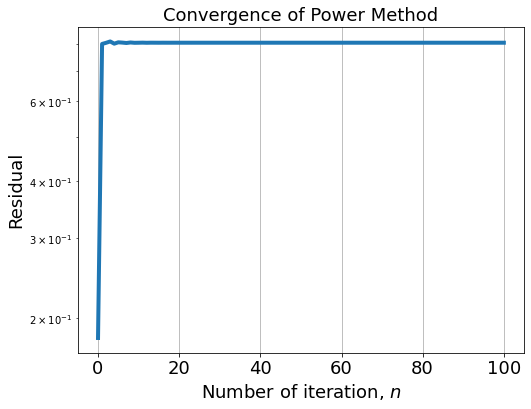

In [13]:
plt.figure(figsize=(8, 6))
plt.semilogy(res, linewidth=4)
plt.ylabel(r"Residual", fontsize=18)
plt.xlabel(r"Number of iteration, $n$", fontsize=18)
plt.grid(True)
plt.title(r"Convergence of Power Method", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);

Because 𝜆1=𝜆2, Power Method does not converge.

* (2 pts) Consider the same graph, but with additional self loop at node 4 (self loop is an edge that connects a vertex with itself). Plot residuals as in the previous task and discuss the convergence. Now, run the power method with ```num_iter=100``` for 10 different initial guesses and print/plot the resulting approximated eigenvectors. Why do they depend on the initial guess?

In [14]:
G_1 = np.array([[0,0,1,0,0], 
              [1,0,1,0,0],
              [0,1,0,0,0],
              [0,0,0,0,1],
              [0,0,0,1,1]
             ])

A_1 = pagerank_matrix(G_1)

In [15]:
v = np.random.rand(5)
x_1, l_1, res_1 = power_method(A_1, v, 100)

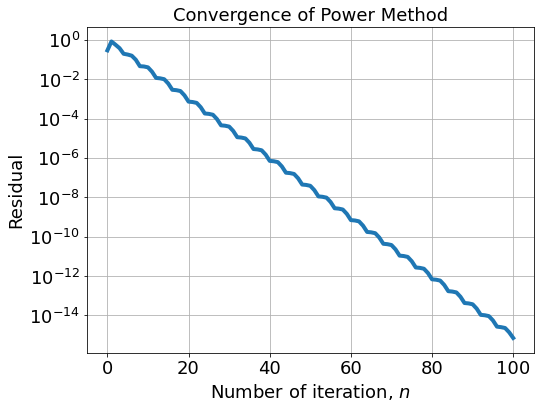

In [16]:
plt.figure(figsize=(8, 6))
plt.semilogy(res_1, linewidth=4)
plt.ylabel(r"Residual", fontsize=18)
plt.xlabel(r"Number of iteration, $n$", fontsize=18)
plt.grid(True)
plt.title(r"Convergence of Power Method", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);

From this figure we can see that now Power Method perfectly converge.

In [17]:
vectors = np.zeros((10, 5))
for i in range(10):
    v = np.random.rand(5)
    x_, l_, res_ = power_method(A_1, v, 100)
    vectors[i] = x_

In [18]:
print(vectors)

[[0.17165623 0.34331246 0.34331246 0.38335551 0.76671103]
 [0.1515502  0.30310039 0.30310039 0.39831968 0.79663936]
 [0.29674157 0.59348314 0.59348314 0.20371547 0.40743094]
 [0.30115    0.60230001 0.60230001 0.19171754 0.38343508]
 [0.28094059 0.56188118 0.56188118 0.24068712 0.48137425]
 [0.17512767 0.35025535 0.35025535 0.38051877 0.76103754]
 [0.21746366 0.43492731 0.43492731 0.3389354  0.6778708 ]
 [0.19711145 0.39422291 0.39422291 0.36064489 0.72128978]
 [0.28500518 0.57001035 0.57001035 0.23192604 0.46385208]
 [0.24127348 0.48254696 0.48254696 0.30857219 0.61714437]]


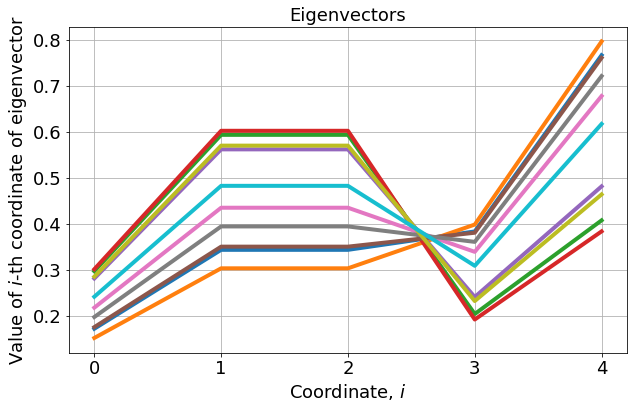

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(vectors.T,  linewidth=4);
plt.ylabel(r"Value of $i$-th coordinate of eigenvector", fontsize=18)
plt.xlabel(r"Coordinate, $i$", fontsize=18)
plt.xticks(range(5))
plt.grid(True)
plt.title(r"Eigenvectors", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);

In order to avoid this problem Larry Page and Sergey Brin [proposed](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) to use the following regularization technique:

$$
A_d = dA + \frac{1-d}{N} \begin{pmatrix} 1 & \dots & 1 \\ \vdots & & \vdots \\ 1 & \dots & 1 \end{pmatrix},
$$

where $d$ is a small parameter in $[0,1]$ (typically $d=0.85$), which is called **damping factor**, $A$ is of size $N\times N$. Now $A_d$ is the matrix with multiplicity of the largest eigenvalue equal to 1. 
Recall that computing the eigenvector of the PageRank matrix, which corresponds to the largest eigenvalue, has the following interpretation. Consider a person who stays in a random node of a graph (i.e. opens a random web page); at each step s/he follows one of the outcoming edges uniformly at random (i.e. opens one of the links). So the person randomly walks through the graph and the eigenvector we are looking for is exactly his/her stationary distribution â€” for each node it tells you the probability of visiting this particular node. Therefore, if the person has started from a part of the graph which is not connected with the other part, he will never get there.  In the regularized model, the person at each step follows one of the outcoming links with probability $d$ OR teleports to a random node from the whole graph with probability $(1-d)$.

* (2 pts) Now, run the power method with $A_d$ and plot residuals $\|A_d x_k - \lambda_k x_k\|_2$ as a function of $k$ for $d=0.97$, ```num_iter=100``` and a random initial guess ```x0```.

In [20]:
def pagerank_matrix_damp(G):
    d = 0.97 #damping factor
    N = G.shape[0]
    k = G.sum(axis=0)
    if(sp.issparse(G)):
        S=sp.spdiags(np.array(1 / k)[0], [0], N, N, 'csr')
        A = d * G * S + ((1 - d) / N) * np.ones(N)
    else:
        A = d * G / k + ((1 - d) / N) * np.ones(N)
    return A

In [21]:
A_d = pagerank_matrix_damp(G)
v = np.random.rand(5)
x_d, l_d, res_d = power_method(A_d, v, 100)

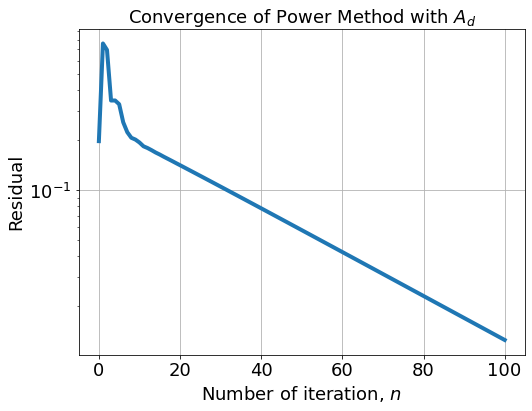

In [22]:
plt.figure(figsize=(8, 6))
plt.semilogy(res_d, linewidth=4)
plt.ylabel(r"Residual", fontsize=18)
plt.xlabel(r"Number of iteration, $n$", fontsize=18)
plt.grid(True)
plt.title(r"Convergence of Power Method with $A_d$", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);

* (5 pts) Find the second largest in the absolute value eigenvalue of the obtained matrix $A_d$. How and why is it connected to the damping factor $d$? What is the convergence rate of the PageRank algorithm when using damping factor?

In [23]:
print( np.sort(abs(np.linalg.eig(A_d)[0]))[::-1])

[1.         0.97       0.97       0.68589358 0.68589358]


The second largest in the absolute value eigenvalue of the obtained matrix  𝐴𝑑  is 0.97. And it is equal to the damping factor.

Usually, graphs that arise in various areas are sparse (social, web, road networks, etc.) and, thus, computation of a matrix-vector product for corresponding PageRank matrix $A$ is much cheaper than $\mathcal{O}(N^2)$. However, if $A_d$ is calculated directly, it becomes dense and, therefore, $\mathcal{O}(N^2)$ cost grows prohibitively large for  big $N$.

* (2 pts) Implement fast matrix-vector product for $A_d$ as a function ```pagerank_matvec(A, d, x)```, which takes a PageRank matrix $A$ (in sparse format, e.g., ```csr_matrix```), damping factor $d$ and a vector $x$ as an input and returns $A_dx$ as an output. 

In [24]:
# INPUT:  A - np.ndarray (2D), d - float (from 0.0 to 1.0), x - np.ndarray (1D, size of A.shape[0/1])
# OUTPUT: y - np.ndarray (1D, size of x)
def pagerank_matvec(A, d, x): # 2 pts
    N = A.shape[0]
    y = d * A @ x + (1 - d) / N * x
    return y

* (1 pts) Generate a random adjacency matrix of size $10000 \times 10000$ with only 100 non-zero elements and compare ```pagerank_matvec``` performance with direct evaluation of $A_dx$.

In [25]:
from scipy.sparse import random

a = random(10000, 10000, density=0.000001)
v = np.random.rand(10000)

In [26]:
%timeit pagerank_matvec(a, 0.97, v)

87.7 µs ± 1.25 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [27]:
N = a.shape[0]
%timeit np.dot((0.97 * a + (1 - 0.97) / N * np.ones(N)), v)

330 ms ± 9.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### DBLP: computer science bibliography

Download the dataset from [here](https://goo.gl/oZVxEa), unzip it and put `dblp_authors.npz`  and `dblp_graph.npz` in the same folder with this notebook. Each value (author name) from `dblp_authors.npz` corresponds to the row/column of the matrix from `dblp_graph.npz`. Value at row `i` and column `j` of the matrix from `dblp_graph.npz` corresponds to the number of times author `i` cited papers of the author `j`. Let us now find the most significant scientists according to PageRank model over DBLP data.

* (4 pts) Load the weighted adjacency matrix and the authors list into Python using ```load_dblp(...)``` function. Print its density (fraction of nonzero elements). Find top-10 most cited authors from the weighted adjacency matrix. Now, make all the weights of the adjacency matrix equal to 1 for simplicity (consider only existence of connection between authors, not its weight). Obtain the PageRank matrix $A$ from the adjacency matrix and verify that it is stochastic.

In [28]:
from scipy.sparse import load_npz
import numpy as np
def load_dblp(path_auth, path_graph):
    G = load_npz(path_graph).astype(float)
    with np.load(path_auth) as data: authors = data['authors']
    return G, authors
G, authors = load_dblp('dblp_authors.npz', 'dblp_graph.npz')

In [29]:
print('Density:')
print(G.getnnz() / G.shape[0] / G.shape[1])

Density:
4.498651815230578e-05


In [30]:
citations = G.sum(axis = 1).reshape(1, -1)
ind = np.argpartition(citations[0, :], -10)[0, -10:]
print('top-10 most cited authors:')
print(authors[ind][0, :])

top-10 most cited authors:
['Jun Zhang' 'Lei Wang' 'Philip S. Yu' 'Wei Li' 'Jun Wang' 'Wei Zhang'
 'Dacheng Tao' 'Yang Liu' 'Lei Zhang' 'Wei Wang']


In [31]:
G[G != 0] = 1

In [32]:
print(G.getnnz() / G.shape[0] / G.shape[1])

4.498651815230578e-05


In [33]:
A = pagerank_matrix(G)

In [34]:
A.sum(axis = 0)

matrix([[1., 1., 1., ..., 0., 0., 0.]])

* (1 pts) In order to provide ```pagerank_matvec``` to your ```power_method``` (without rewriting it) for fast calculation of $A_dx$, you can create a ```LinearOperator```: 
```python
L = scipy.sparse.linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))
```
Calling ```L@x``` or ```L.dot(x)``` will result in calculation of ```pagerank_matvec(A, d, x)``` and, thus, you can plug $L$ instead of the matrix $A$ in the ```power_method``` directly. **Note:** though in the previous subtask graph was very small (so you could disparage fast matvec implementation), here it is very large (but sparse), so that direct evaluation of $A_dx$ will require $\sim 10^{12}$ matrix elements to store - good luck with that (^_<).

* (2 pts) Run the power method starting from the vector of all ones and plot residuals $\|A_dx_k - \lambda_k x_k\|_2$  as a function of $k$ for $d=0.85$.


* (1 pts) Print names of the top-10 authors according to PageRank over DBLP when $d=0.85$. Comment on your findings.

In [35]:
from scipy.sparse.linalg import LinearOperator
d = 0.85
L = LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))

In [36]:
v = np.ones(A.shape[0])
x, l, res = power_method(L, v, 100)

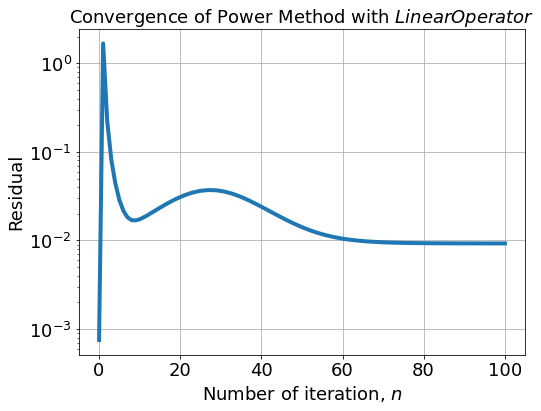

In [37]:
plt.figure(figsize=(8, 6))
plt.semilogy(res, linewidth=4)
plt.ylabel(r"Residual", fontsize=18)
plt.xlabel(r"Number of iteration, $n$", fontsize=18)
plt.grid(True)
plt.title(r"Convergence of Power Method with $LinearOperator$", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);

### 3. QR algorithm (10 pts)

* Implement QR-algorithm without shifting. Prototype of the function is given below

In [38]:
# INPUT: 
# A_init - square matrix, 
# num_iter - number of iterations for QR algorithm
# OUTPUT: 
# Ak - transformed matrix A_init given by QR algorithm, 
# convergence - numpy array of shape (num_iter, ), 
# where we store the maximal number from the Chebyshev norm 
# of triangular part of the Ak for every iteration
from scipy.linalg import qr


def qr_algorithm(A_init, num_iter): # 3 pts
    # enter your code here
    Ak = A_init
    convergence = np.ones(num_iter)
        
    for k in range(num_iter):
        Q, R = qr(Ak)
        Ak = R @ Q
        low_part = np.tril(Ak, -1)
        convergence[k] = np.linalg.norm(low_part, np.inf)
    return Ak, convergence

#### Symmetric case (3 pts)
- Create symmetric tridiagonal $11 \times 11$ matrix with elements $-1, 2, -1$ on sub-, main- and upper diagonal respectively without using loops.
- Run $400$ iterations of the QR algorithm for this matrix.
- Plot the output matrix with function ```plt.spy(Ak, precision=1e-7)```.
- Plot convergence of QR-algorithm.

In [39]:
A_init = diags([-1, 2, -1], [-1, 0, 1], shape = (11, 11)).toarray()

In [40]:
Ak, convergence = qr_algorithm(A_init, 400)

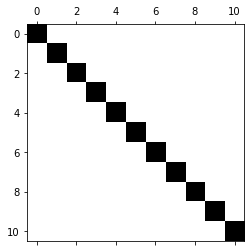

In [41]:
plt.spy(Ak, precision=1e-7)

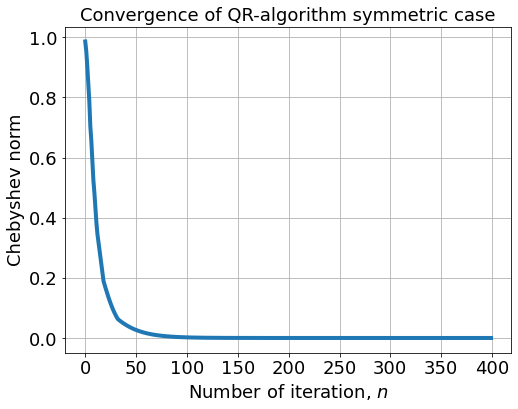

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(convergence, linewidth=4)
plt.ylabel(r"Chebyshev norm", fontsize=18)
plt.xlabel(r"Number of iteration, $n$", fontsize=18)
plt.grid(True)
plt.title(r"Convergence of QR-algorithm symmetric case", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);

#### Nonsymmetric case (4 pts)

- Create nonsymmetric tridiagonal $11 \times 11$ matrix with elements $5, 3, -2$ on sub-, main- and upper diagonal respectively without using loops.
- Run $250$ iterations of the QR algorithm for this matrix.
- Plot the result matrix with function ```plt.spy(Ak, precision=1e-7)```. Is this matrix lower triangular? How does this correspond to the claim about convergence of the QR algorithm?

In [43]:
A_init = diags([5, 3, -2], [-1, 0, 1], shape = (11, 11)).toarray()

In [44]:
Ak, convergence = qr_algorithm(A_init, 250)

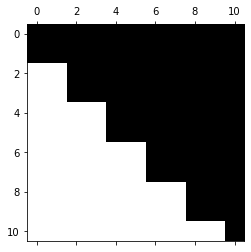

In [45]:
plt.spy(Ak, precision=1e-7);

After 250 steps matrix A is nearly, but not quite, upper-triangular. The sequence A0,A1,…, computed by the unshifted QR algorithm above does not always converge. It is always convege for symmetric case.

## Problem 3. (Pseudo-Schur decomposition) 15 pts
Let's redefine scalar product $ \forall x, y \in \mathbb{C}^n$ in a following way:

$$ [x,y]_J = y^{*}Jx, \text{s.t.}\ J = \text{diag}(j_{11}, j_{22}, \dots, j_{nn})\ \text{and}\ j_{ii} = \pm1\ \forall i \in [1,n].$$

Denote rows of matrix $V \in \mathbb{C}^{n \times n}$ as $v_1, v_2, \dots, v_n$. Then $V$ is called $\textbf{J-orthonormal}$ iff 

$$[v_i, v_k]_J = \pm \delta_{ik}.$$

We will call matrix $T \in \mathbb{C}^{n \times n}$ $\textbf{almost triangular}$ iff $T$ is upper triangular with diagonal blocks of order $1$ or $2$.

Matrix $A \in \mathbb{C}^{n \times n}$ is said to be $\textbf{J-decomposable}$ if exist J-orthonormal matrix $V$ and upper triangular matrix $T$ such that 


$$A = V T V^{-1}.$$

Matrix $A \in \mathbb{C}^{n \times n}$ is said to have $\textbf{pseudoschur J-decomposition}$ if exist J-orthonormal matrix $V$ and almost triangular matrix $T$ such that


$$A = V T V^{-1}.$$

This problem is to get familiar with the fact that two abovementioned decompositions exist not for any square matrix with complex entries.




- (2 pts) $A$ has pseudoschur J-decomposition $A = V T V^{-1}, \ \text{where}\ V = \begin{bmatrix} v_1 & v_2 &  \ldots & v_n \end{bmatrix}, \ T = \begin{bmatrix} T_{ij} \end{bmatrix}$ and $v_1$ is $\textbf{not}$ an eigenvector of $A$. Show that $T_{21} \ne 0$. 



- (5 pts) Given $J = \text{diag}(1, -1)$ and $A = \begin{bmatrix}
3   \ -1\\
-1\   \ 3\\
\end{bmatrix}$, prove that $A$ is not J-decomposable.


- (8 pts) Given that $A \in \mathbb{C}^{n \times n}$ is diagonalizable, show that it has pseudoschur J-decomposition for any $J$ of form $J=\text{diag}(\pm 1, \dots, \pm 1)$.
Note that in order to solve that subproblem you should firstly prove the following fact:

    Let $S \in \mathbb{C}^{m \times n},\ m \ge n,\ J = \text{diag}(\pm 1).$ If $A = S^{*}JS$ and $det(A) \ne 0$, then exists QR decomposition of $S$ with respect to $J$: 
    $$S = P_1 QR P_2^{*} = P_1 Q \begin{bmatrix} R_1 \\ 0 \end{bmatrix} P_2^{*}, \ Q^{*} J^{'}Q = J^{'}, \ J^{'} = P_1^{*}JP_1,$$ where $P_1$ and $P_2$ are permutation matrices, $Q$ is called $J^{'}$- unitary and $R_1$ is almost triangular.


In [46]:
# Your solutuion is here

## Problem 4. (Skeleton decomposition) 28 pts

The application that we are particularly interested in is
the approximation of a given matrix by a low-rank matrix:

$$ A \approx UV^T, A \in \mathbb{R}^{m \times n}, U \in \mathbb{R}^{m \times r}, V \in \mathbb{R}^{n \times r}.$$

It is well known that the best (in any unitary invariant norm) low-rank approximation can be computed via singular value decomposition (SVD). As an alternative, we can consider skeleton decompostion of the form:

$$A \approx A_r = A(: , \mathcal{J})A(\mathcal{I} , \mathcal{J})^{-1}A(\mathcal{I} , :),$$
where $\mathcal{I,J}$ are some index sets of length $r$.

Below we consider the matrix $N \times N$ derived from the following function discretization in the uniform grid in square $[0, 1] \times [0, 1]$:
$ f(x, y) = \exp(-\sqrt{x^2 + y^2})$.
It means that $A = [a_{ij}]$, where $a_{ij} = f(x_i, x_j)$ and $x_i = i / (N-1)$, $x_j = j / (N-1)$, where $i, j = 0,\ldots, N-1$.

- (2 pts) compose this matrix for $N = 5000$ without loops (Hint: function ```np.meshgrid``` can help you)


In [47]:
N = 5000
x = [ i / (N - 1) for i in range(N)]

xx, yy = np.meshgrid(x, x, sparse=True)
A = np.exp(- np.sqrt(xx**2 + yy**2))

- (3 pts) Compute Skeleton approximation with random selection of rows and columns indices for $r = 5$ (check that submatrix in the intersection of rows and columns is nonsingular). Average the relative error $\frac{\|A - A_r \|_F}{\|A\|_F}$ over $M$ samples of column/row indices. Check that $M$ is sufficiently large to provide stable mean.

 Note: extracting submatrices should be done according to ```numpy```  e.g. ```A[index_set, :]``` to extract selected rows, ```A[:, index_set]``` to extract selected columns etc..


In [48]:
error = 0
M = 500
m = 0
for i in range(M):
    index_set = np.random.randint(N, size = 5)

    rows = A[index_set, :]
    cols = A[:, index_set]

    sub = A[np.ix_(index_set, index_set)]
    try:
        inv = np.linalg.inv(sub)
        Ar = cols @ inv @ rows
        error += np.linalg.norm(A - Ar, 'fro') / np.linalg.norm(A, 'fro')
        m += 1
    except:
        pass

print(error / m)

0.004858443316010227


As you should know from the lecture, if $A$ is of rank $r$ and $\hat{A} = A(\mathcal{I} , \mathcal{J})$ is nonsingular, then the exact equality holds. In the approximate case, however, the quality of the approximation depends on the volume of the submatrix $\hat{A}$: 

**Theorem**

*If $\hat{A} = A_{max}$ has maximal in modulus determinant among all $r \times r$ submatrices of $A$, the following error etimate holds:*

$$ \|A - A_r\|_1 \leq (r+1)\sigma_{r+1}.$$


And the question is how to choose a good submatrix of nearly maximal volume in practice.

**Definition**: *We call $r \times r$ submatrix $A_{dom}$ of rectangular $n \times r$ matrix $A$ of
full rank dominant, if all the entries of $AA_{dom}^{-1}$ are not greater than $1$ in
modulus.*

The crucial theoretical result behind the scene is that the volume of any dominant submatrix $A_{dom}$ can not be very much smaller than the maximum volume submatrix $A_{max}$ (without proof).

We provide the following algorithm for constructing dominant submatrix of a tall matrix.

**Algorithm 1**: 
    
Given matrix $A$ of size $n \times r$ finds dominant submatrix of size $r \times r$

__step 0.__ Start with arbitrary nonsingular $r \times r$ submatrix $A_{dom}$. Reorder rows in $A$ so that $A_{dom}$ occupies first $r$ rows in $A$.

__step 1.__ Compute $B = AA_{dom}^{-1}$ and find its maximum in module  entry $b_{ij}$.

__step 2.__ **If $|b_{ij}| > 1 + \delta$, then**:

Swap rows $i$ and $j$ in $B$ (accrodignly in A). By swapping the rows we have increased the volume of the upper submatrix in $B$, as well as in $A$ (why?). Let $A_{dom}$ be the new upper submatrix of $A$ and go to __step 1__.

**elseif $|b_{ij}| < 1 + \delta$**:

return $A_{dom}$.

Note: $\delta = 10^{-2}$ seems to be a good practical choice.

- (10 pts) Implement algorithm 1 according to the following signature, where the function returns ```row_indices``` array which can be used as ```A[row_indices, :]``` to extract selected submatrix.

Note that matrix inverse $A_{dom}^{-1}$ in step 3 has to be updated efficiently using [Shermann-Morison formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula) (inverse of rank-1 update).

In [49]:
def dominant_submatrix_search(A):
    delta = 0.01
    r = A.shape[1]  
    A_1 = A.copy()
    
    while 1:
        index_set = np.random.randint(n, size = r)
        A_dom = A[np.ix_(index_set, np.arange(r))]
        try:
            A_dom_inv = np.linalg.inv(A_dom)
            break
        except:
            pass
    
    for i in range(r):
        j = np.where(np.all(A == A_dom[i,:], axis=1) == True)[0][-1]
        A[[i, j], :] = A[[j, i], :]
    

    B = A @ A_dom_inv
    b = np.max(np.abs(B))
    
    while b > 1 + delta:
        i, j = np.where(np.abs(B) == b)
        A[[i, j], :] = A[[j, i], :]
        A_dom = A[:r,:]

        A_dom_inv = np.linalg.inv(A_dom)
        B = A @ A_dom_inv
        b = np.max(np.abs(B))

    row_indices = []
    
    for i in range(r):
        j = np.where(np.all(A_1 == A_dom[i,:], axis=1) == True)[0][-1]
        row_indices.append(j)
        
    return row_indices

In [50]:
# check the convergence of your implementation on random data
row_indices = dominant_submatrix_search(np.random.rand(50, 10))
row_indices

KeyboardInterrupt: 

- (10 pts) Propose the method to construct Skeleton approximation using Algorithm 1. The signature of the function is provided below.  Compare your algorithm with previously considered random selection on the matrix $A$.

Hint: 

1) start with random selection of columns 

2) if you transpose the matrix for which you find rows, then Algorithm 1 will give you update for columns in the initial matrix

In [ ]:
def skeleton(A, r):
    # Your code is here
    return row_indices, column_indices

- (3 pts) Compare your ```skeleton``` approximation algorithm with SVD and discuss its pros and cons.

In [ ]:
# Your solution is here